In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from cvxopt import matrix, solvers
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
def load_split_dataset():
    iris = load_iris()
    x = iris.data
    y = iris.target
    class_1 = 1  
    class_2 = 2 
    binary_x = x[(y == class_1) | (y == class_2)]
    binary_y = y[(y == class_1) | (y == class_2)]
    label_encoder = LabelEncoder()
    binary_y = label_encoder.fit_transform(binary_y)
    x_train, x_test, y_train, y_test = train_test_split(binary_x, binary_y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

if __name__ =="__main__":
    X_train, X_test, y_train, y_test = load_split_dataset()
    
    
y_train = np.where(y_train == 0, -1, y_train)
y_train = y_train.reshape(y_train.shape[0] , 1)
y_test = np.where(y_test == 0, -1, y_test)
y_test = y_test.reshape(y_test.shape[0] , 1)

change_y_index = np.where(y_train == 0)
for i in change_y_index:
    y_train[i] = -1

# Primal problem $( min  W1 , W2 ,W3  )$
## This Function return weights and biase of Line 

In [2]:
def linear_svm_primal_C(data_x , data_y , c):
#     first matrix Quadratic form 
    m = data_x.shape[1]
    n = data_x.shape[0]
    mx_1 = np.zeros((m + n + 1 , m + n + 1 ))
    mx_1[0][0] = 1
    mx_1[1][1] = 1
    mx_1[2][2] = 1
    mx_1[3][3] = 1
    
#     second matrix Quadratic form
    mx_2 = c * np.ones( n + m + 1 )
    mx_2[0] = 0
    mx_2[1] = 0
    mx_2[2] = 0
    mx_2[3] = 0
    mx_2[4] = 0
    
    

#     third matrix inequality constraiont 
    mx_3_1_1 = np.concatenate((data_x , np.ones(n).reshape(-1,1) ) , axis=1)
    mx_3_1_1 = -1 * mx_3_1_1 * data_y.reshape(data_y.shape[0] , 1)
    
    mx_3_1_2 = -1*np.eye(n)
    
    mx_3_2_1 = np.zeros((n,5))
    
    mx_3_2_2 = -1* np.eye(n)
    
    mx_3_1 = np.concatenate((mx_3_1_1 , mx_3_1_2) , axis = 1)
    mx_3_2 = np.concatenate((mx_3_2_1 , mx_3_2_2) , axis = 1)
    
    mx_3 = np.concatenate((mx_3_1 , mx_3_2) , axis = 0)
    
    
    mx_4 = -1 * np.ones(n).reshape(-1,1)
    mx_4_1 = np.zeros(n).reshape(-1,1)
    mx_4_2 = np.concatenate((mx_4 , mx_4_1 ) , axis = 0)
    
    
    
    p = matrix(mx_1)
    q = matrix(mx_2)
    g = matrix(mx_3)
    h = matrix(mx_4_2)
    
    sol = solvers.qp(p,q,g,h)
    
    return sol

# linear_svm_primal_C(X_train , y_train , 10)
w_primal_soft = []
for w in linear_svm_primal_C(X_train , y_train , 10)['x'] :
    w_primal_soft.append(w)
    
w_primal_soft = np.array(w_primal_soft)
w_primal_soft = w_primal_soft[:5]
w_primal_soft

     pcost       dcost       gap    pres   dres
 0: -6.8060e+03  4.7544e+03  2e+04  2e+01  7e+00
 1:  5.1333e+02 -7.6964e+02  3e+03  2e+00  7e-01
 2:  1.3081e+02 -8.4536e+01  3e+02  2e-01  5e-02
 3:  7.8292e+01  2.1074e+00  9e+01  3e-02  1e-02
 4:  5.4717e+01  2.3082e+01  4e+01  1e-02  3e-03
 5:  4.1460e+01  3.2457e+01  1e+01  1e-03  3e-04
 6:  3.9962e+01  3.5420e+01  5e+00  9e-05  3e-05
 7:  3.7683e+01  3.6831e+01  9e-01  6e-06  2e-06
 8:  3.7189e+01  3.7175e+01  1e-02  6e-08  2e-08
 9:  3.7182e+01  3.7181e+01  1e-04  6e-10  2e-10
10:  3.7181e+01  3.7181e+01  1e-06  6e-12  2e-12
Optimal solution found.


array([-0.82057721, -1.73051686,  2.39600963,  3.62226486, -7.59277309])

# Dual problem $(maxmize  \lambda_1 , \lambda_2 , \lambda_3 , \lambda_4 , ... )$
## this function return lagrangian mul 
we want to solve this equation :  $ - \sum\limits_{i=1}^N \sum\limits_{j=1}^N \lambda_i \lambda_j y_i y_j x_i x_j + \sum\limits_{i=1}^N \lambda_i  $ subject to :  $ 0 < \lambda_i \leq c $ and
$ \sum\limits_{i=1}^N \lambda_i y_i = 0  $
# we can get $ W $ from $ \lambda $ : 
# $ w =  \sum\limits_{i=1}^N \lambda_i y_i x_i $
# we can get $ Bias $ from this :
## $ \lambda_i (y_i (wx_i + b )) = 1 $

In [3]:
def linear_svm_dual(x , y , c):
#     y_i*y_j*x_i*x_j
    P = -1 * matrix( -(y @ y.T) * (x @ x.T) , tc='d')
#     sigma landa
    q = -1 * matrix( np.ones( x.shape[0] ) , tc='d' )
#   inequality constraint :  landa sould be positive and sould be less than c and we should get this two constraint in one matrix 
    G = matrix( np.concatenate( (-1 * np.eye(x.shape[0]) , np.eye(x.shape[0]) ) ) )
    h = matrix( np.concatenate(  (np.zeros(x.shape[0]) ,np.ones(x.shape[0]) * c )  ) )
#   equality constraint  :  landa * y = 0
    A = matrix( y , (1 , x.shape[0] ) , tc='d')
    b = matrix( 0.0 )
#     print(P.shape(),q.shape(),G.shape(),h.shape(),A.shape(),b.shape())
    sol = solvers.qp(P , q , G , h , A , b)
    
    return sol


def w_dual(landa , x , y ):
    w_dual = np.zeros(x.shape[1])
    for i in range(0,x.shape[0]):
        w_dual += landa[i] * y[i] * x[i]
        
    list_of_big_landa = []
    for i in range (0,landa.shape[0]):
        if landa[i] > 10**-5 :
            list_of_big_landa.append(i)
            
            
    w_x_mul = w_dual @ x[list_of_big_landa].T
    w_x_mul = w_x_mul.reshape(-1,1)
    
    
    sum_bias_dual = y[list_of_big_landa] - w_x_mul
    bias_dual = sum_bias_dual.sum() / sum_bias_dual.shape[0]
    bias_dual = np.array([bias_dual])
    w_dual = np.concatenate((w_dual , bias_dual) , axis = 0)
    
    return(w_dual)

landa_coef_soft = []
for landa in linear_svm_dual(X_train , y_train , 10)['x'] :
    landa_coef_soft.append(landa)
landa_coef_soft = np.array(landa_coef_soft).reshape(-1,1)
w_dual_soft = w_dual(landa_coef_soft , X_train , y_train )

     pcost       dcost       gap    pres   dres
 0:  1.8087e+01 -5.9665e+03  2e+04  8e-01  4e-13
 1:  1.4317e+02 -1.8823e+03  3e+03  9e-02  4e-13
 2:  5.5497e+01 -2.2495e+02  3e+02  6e-03  3e-13
 3: -5.2515e+00 -9.6919e+01  9e+01  1e-03  3e-13
 4: -2.3713e+01 -6.0336e+01  4e+01  4e-04  3e-13
 5: -3.2498e+01 -4.2049e+01  1e+01  4e-05  3e-13
 6: -3.5423e+01 -4.0015e+01  5e+00  3e-06  4e-13
 7: -3.6831e+01 -3.7686e+01  9e-01  2e-07  4e-13
 8: -3.7175e+01 -3.7189e+01  1e-02  2e-09  3e-13
 9: -3.7181e+01 -3.7182e+01  1e-04  2e-11  3e-13
10: -3.7181e+01 -3.7181e+01  1e-06  2e-13  3e-13
Optimal solution found.


In [4]:
print(w_dual_soft)
print(w_primal_soft)

[-0.82057721 -1.73051686  2.39600963  3.62226486 -7.76676362]
[-0.82057721 -1.73051686  2.39600963  3.62226486 -7.59277309]


# Strong Duality 

In [5]:
def dist(x,y):
    c = 0
    for i in zip(x,y):
        c += (i[0] - i[1]) ** 2
    return c**0.5
strong_duality = dist(w_dual_soft,w_primal_soft)
print(strong_duality)

0.17399052674241577


## Interference between weights is near to zero so we have Strong Duality 

### this function give X , Y , W and return Recall , Precision , F_score , accuracy 
## for test data and Accuracy

In [6]:
def data_eror(x , y , w):
    xx_test = np.concatenate((x , np.ones(x.shape[0]).reshape(-1,1)),axis = 1)
    
    total_data = x.shape[0]
    y_is_true = np.where(y == 1)[0]
    y_is_false = np.where(y == -1)[0]
    

    y_true = []
    x_true = []
    

    y_false = []
    x_false = []
    
    for i in y_is_true :
        y_true.append(y[i])
        x_true.append(xx_test[i])
        
    for i in y_is_false :
        y_false.append(y[i])
        x_false.append(xx_test[i])
        
    y_true = np.array(y_true)
    y_false = np.array(y_false)
    x_true = np.array(x_true)
    x_false = np.array(x_false)
    
        
    
    test_true = x_true @ w
    test_true = test_true.reshape(test_true.shape[0] , 1)
    values_true = test_true * y_true
    
    test_false = x_false @ w
    test_false = test_false.reshape(test_false.shape[0] , 1)
    values_false = test_false * y_false
    
    T_P = values_true > 0
    T_P = T_P.sum()
    
    T_N = values_false > 0
    T_N = T_N.sum()
    
    F_P = values_false < 0
    F_P = F_P.sum()
    
    F_N = values_true < 0
    F_N = F_N.sum()
    


    
    Recall, Precision, accuracy = T_P / (T_P + F_N ) , T_P / (T_P + F_P) , (T_P + T_N) / (T_P + T_N + F_P + F_N)
    F_score = (2 * Precision * Recall ) / (Precision + Recall )
    
    return Recall , Precision , F_score , accuracy , T_P , T_N , F_P , F_N

In [7]:
def visualize(x , y , w):
    print('Evaluation for test (primal) : ')
    print('Recall = ' ,data_eror(x , y , w)[0] )
    print('Precision = ' ,data_eror(x , y , w)[1] )
    print('F_score = ' ,data_eror(x , y , w)[2] )
    print('accuracy = ' ,data_eror(x , y , w)[3] )
    confu_primal_test = np.array([[data_eror(x , y , w)[4],  data_eror(x , y , w)[6]],[ data_eror(x , y , w)[7], data_eror(x , y , w)[5]]])
    sns.heatmap(confu_primal_test, annot=True)

In [8]:
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

def show_line(data, labels, w):
    
    weights  = w[:4]
    bias = w[-1]
    
    
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    
    x_min_val = data_pca[:, 0].min() - 1
    x_max_val = data_pca[:, 0].max() + 1
    y_min_val = data_pca[:, 1].min() - 1
    y_max_val = data_pca[:, 1].max() + 1
    
    x_vals, y_vals = np.meshgrid(np.linspace(x_min_val, x_max_val, 50), np.linspace(y_min_val, y_max_val, 50))
    
    transformed_data = pca.inverse_transform(np.c_[x_vals.ravel(), y_vals.ravel()])
    predictions = predict(transformed_data, weights, bias)
    predictions = predictions.reshape(x_vals.shape)
    
    plt.contourf(x_vals, y_vals, predictions, alpha=0.6, levels=[-1, 0, 1], colors=['blue', 'red'])
    
    
    colors = []
    for  i in labels :
        if i == -1 :
            colors.append('white')
        else :
            colors.append('black')
            
            
    
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=colors)
    plt.title('Data and Svm line')
    plt.show()

# Primal 

### Train

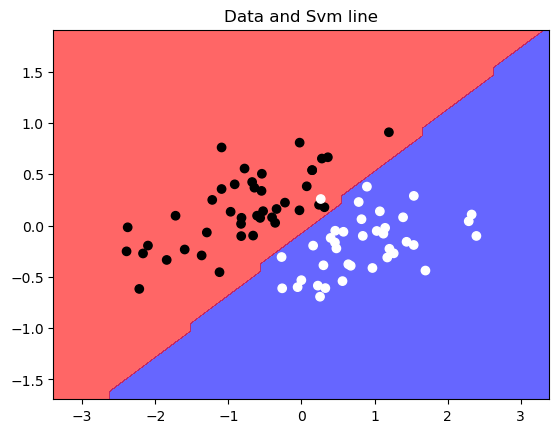

In [9]:
show_line(X_train, y_train , w_primal_soft)

Evaluation for test (primal) : 
Recall =  1.0
Precision =  0.9767441860465116
F_score =  0.988235294117647
accuracy =  0.9875


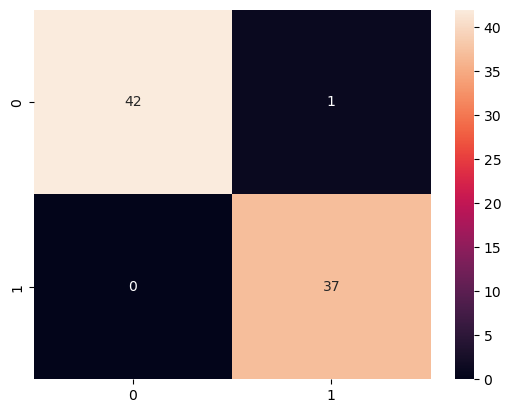

In [10]:
visualize(X_train , y_train ,w_primal_soft )

### Test

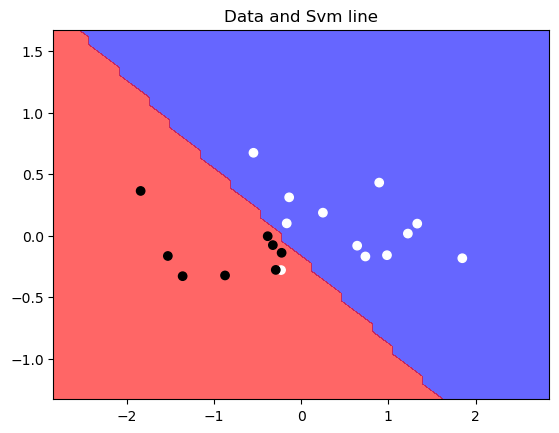

In [11]:
show_line(X_test , y_test , w_primal_soft)

Evaluation for test (primal) : 
Recall =  1.0
Precision =  0.8
F_score =  0.888888888888889
accuracy =  0.9


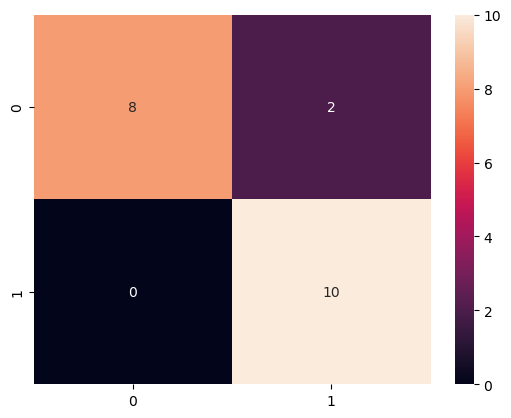

In [12]:
visualize(X_test , y_test ,w_primal_soft )

# Dual 

### Train

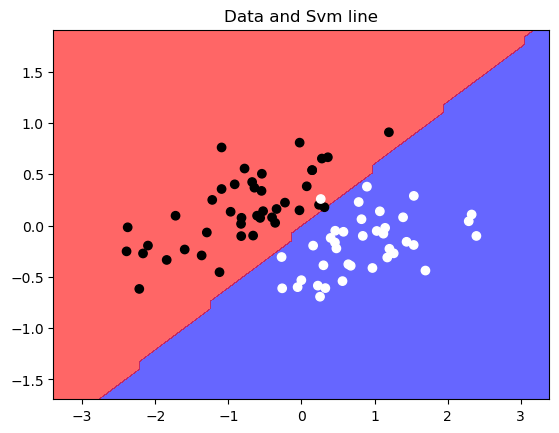

In [13]:
show_line(X_train, y_train , w_dual_soft)

Evaluation for test (primal) : 
Recall =  1.0
Precision =  1.0
F_score =  1.0
accuracy =  1.0


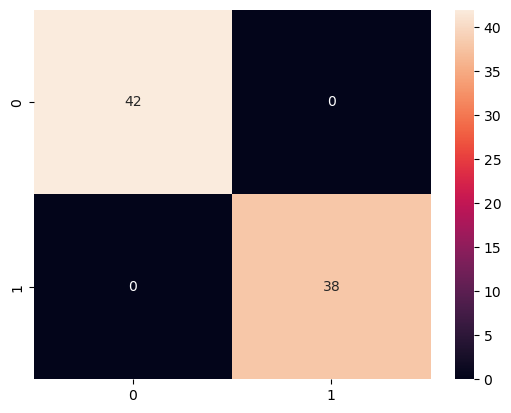

In [14]:
visualize(X_train , y_train ,w_dual_soft )

### Test

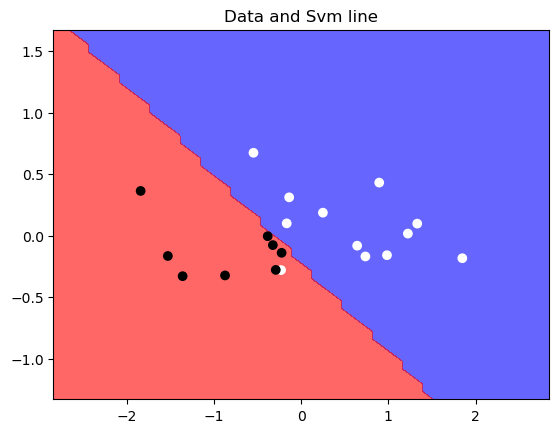

In [15]:
show_line(X_test , y_test , w_dual_soft)

Evaluation for test (primal) : 
Recall =  0.875
Precision =  0.875
F_score =  0.875
accuracy =  0.9


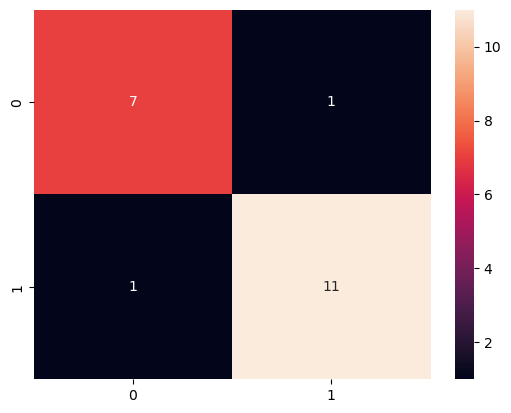

In [16]:
visualize(X_test , y_test ,w_dual_soft )

# Multi Classes

In [17]:
iris = load_iris()
# Now, you can access the features and target variables
X_multi_class = iris.data  # features
y_multi_class = iris.target  # target variable
y_multi_class = y_multi_class.reshape(y_multi_class.shape[0],1)

In order to be able to implement the multi-class mode, we can follow the point of view of placing one class in front of other classes. That is, in each step, we give one class a label of 1 and other classes get a label of -1

In [18]:
def multiclass_svm(x , y , c):
    y1 = np.where(y == 0, 1, -1)
    y2 = np.where(y == 1, 1, -1)
    y3 = np.where(y == 2, 1, -1)
    
    w_1 = []
    w_2 = []
    w_3 = []
    for i in linear_svm_primal_C(x , y1 , c)['x']:
        w_1.append(i)
        
    for i in linear_svm_primal_C(x , y2 , c)['x']:
        w_2.append(i)
    
    for i in linear_svm_primal_C(x , y3 , c)['x']:
        w_3.append(i)
        
    w_1 , w_2 , w_3 = np.array(w_1) , np.array(w_2) , np.array(w_3)
    w_1 , w_2 , w_3 = np.array(w_1[:5]) , np.array(w_2[:5]) , np.array(w_3[:5])
        
    return w_1 , w_2 , w_3 , y1 , y2 , y3

w_1 = []
for i in multiclass_svm(X_multi_class , y_multi_class , 10)[0] :
    w_1.append(i)
w_2 = []
for i in multiclass_svm(X_multi_class , y_multi_class , 10)[1] :
    w_2.append(i)
w_3 = []
for i in multiclass_svm(X_multi_class , y_multi_class , 10)[2] :
    w_3.append(i)
y_1 = []
for i in multiclass_svm(X_multi_class , y_multi_class , 10)[3] :
    y_1.append(i)
y_2 = []
for i in multiclass_svm(X_multi_class , y_multi_class , 10)[4] :
    y_2.append(i)
y_3 = []
for i in multiclass_svm(X_multi_class , y_multi_class , 10)[5] :
    y_3.append(i)

     pcost       dcost       gap    pres   dres
 0: -1.4249e+04  8.4938e+03  3e+04  2e+01  3e+01
 1: -1.1789e+02 -1.2284e+03  4e+03  2e+00  3e+00
 2:  3.0952e+01 -1.6991e+02  5e+02  2e-01  3e-01
 3:  1.5090e+01 -1.2753e+01  3e+01  5e-03  6e-03
 4:  2.9761e+00 -1.0655e+00  4e+00  3e-15  3e-16
 5:  1.0780e+00  1.4376e-01  9e-01  1e-15  5e-16
 6:  8.2854e-01  3.9582e-01  4e-01  1e-15  2e-15
 7:  9.0176e-01  5.1658e-01  4e-01  1e-15  2e-15
 8:  8.1098e-01  6.5641e-01  2e-01  6e-16  3e-15
 9:  7.9469e-01  7.1133e-01  8e-02  7e-16  1e-15
10:  7.4870e-01  7.4750e-01  1e-03  8e-16  6e-15
11:  7.4806e-01  7.4805e-01  1e-05  8e-16  2e-14
12:  7.4806e-01  7.4806e-01  1e-07  7e-16  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.3232e+03  7.2511e+03  2e+04  2e+01  1e+01
 1:  3.4823e+03  4.5734e+02  3e+03  4e-15  2e-14
 2:  1.1141e+03  6.0855e+02  5e+02  4e-15  2e-13
 3:  9.6348e+02  7.5036e+02  2e+02  2e-15  2e-13
 4:  8.9778e+02  7.9545e+02  1e+02  1e-15  2e-1

 9:  8.3845e+02  8.3845e+02  1e-04  1e-15  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2024e+04  6.2747e+03  2e+04  2e+01  9e+00
 1: -2.1018e+03 -8.8728e+02  5e+03  5e+00  2e+00
 2: -6.2281e+02 -6.8938e+02  2e+03  2e+00  8e-01
 3:  4.4915e+01 -9.8210e+01  5e+02  3e-01  1e-01
 4:  1.0354e+02  4.7893e+01  1e+02  4e-02  2e-02
 5:  9.4306e+01  6.9577e+01  4e+01  2e-02  7e-03
 6:  1.0064e+02  7.9694e+01  3e+01  5e-03  2e-03
 7:  9.3134e+01  8.6695e+01  8e+00  1e-03  7e-04
 8:  8.9858e+01  8.9753e+01  1e-01  1e-05  7e-06
 9:  8.9797e+01  8.9796e+01  1e-03  1e-07  7e-08
10:  8.9796e+01  8.9796e+01  1e-05  1e-09  7e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4249e+04  8.4938e+03  3e+04  2e+01  3e+01
 1: -1.1789e+02 -1.2284e+03  4e+03  2e+00  3e+00
 2:  3.0952e+01 -1.6991e+02  5e+02  2e-01  3e-01
 3:  1.5090e+01 -1.2753e+01  3e+01  5e-03  6e-03
 4:  2.9761e+00 -1.0655e+00  4e+00  3e-15  3e-16
 5:  1.0780e+00  1.4376

In [19]:
w_1 = np.array(w_1) 
w_2 = np.array(w_2)
w_3 =  np.array(w_3)
y_1 = np.array(y_1)
y_2 = np.array(y_2)
y_3 = np.array(y_3)

Evaluation for test (primal) : 
Recall =  1.0
Precision =  1.0
F_score =  1.0
accuracy =  1.0


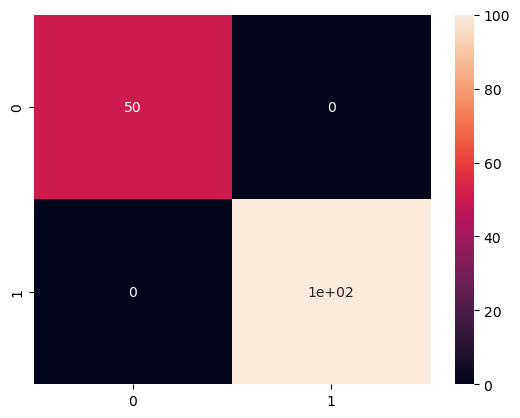

In [20]:
visualize(X_multi_class , y_1 ,w_1 )

Evaluation for test (primal) : 
Recall =  1.0
Precision =  0.9433962264150944
F_score =  0.970873786407767
accuracy =  0.98


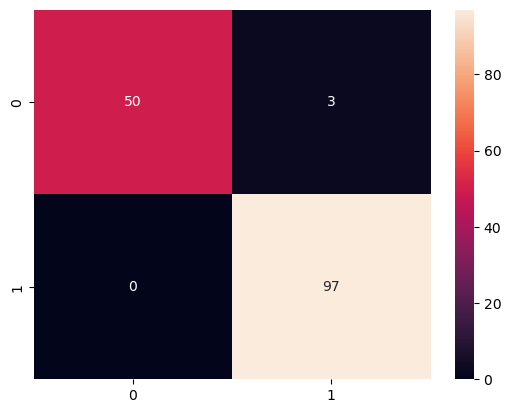

In [21]:
visualize(X_multi_class , y_3 ,w_3 )